# Masters stats doc
Here I show the calculation of all the stats for my time series estimation work. These will be put into a function that returns all of them, which we will then calculate the error of for missing data

- Use ts app code to now run the results on missing data
- Compare utils script to reynolds and update accordingly if needed


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calculate_stats as cs
import src.utils as utils
import src.params as params
import scipy.signal as signal

c:\Users\spann\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
int_wind_hr = pd.read_pickle("data_processed/" + "wind_hr.pkl")
int_wind_lr = pd.read_pickle("data_processed/" + "wind_lr.pkl")

nlags_lr=params.nlags_lr
nlags_hr=params.nlags_hr
dt_lr=float(params.dt_lr[:-1])
dt_hr=float(params.dt_hr[:-1])
f_min_inertial = params.f_min_inertial
f_max_inertial = params.f_max_inertial
f_min_kinetic = params.f_min_kinetic
f_max_kinetic = params.f_max_kinetic
tau_min = params.tau_min
tau_max = params.tau_max

In [48]:
def calculate_all_stats(int_hr, int_lr):
# Compute autocorrelations and power spectra

    time_lags_lr, acf_lr = utils.compute_nd_acf(
        np.array([
            int_lr
        ]),
        nlags=nlags_lr,
        dt=dt_lr)  # Removing "S" from end of dt string

    corr_scale_exp_trick = utils.compute_outer_scale_exp_trick(time_lags_lr, acf_lr)
    # corr_scale_exp_trick_list.append(corr_scale_exp_trick)

    # Use estimate from 1/e method to select fit amount
    corr_scale_exp_fit = utils.compute_outer_scale_exp_fit(
        time_lags_lr, acf_lr, np.round(2*corr_scale_exp_trick))
    # corr_scale_exp_fit_list.append(corr_scale_exp_fit)

    corr_scale_int = utils.compute_outer_scale_integral(time_lags_lr, acf_lr)
    # corr_scale_int_list.append(corr_scale_int)

    time_lags_hr, acf_hr = utils.compute_nd_acf(
        np.array([
            int_hr
        ]),
        nlags=nlags_hr,
        dt=dt_hr)

    # ~1min per interval due to spectrum smoothing algorithm
    try:
        slope_i, slope_k, break_s, f_periodogram, power_periodogram, p_smooth, xi, xk, pi, pk = utils.compute_spectral_stats(
            np.array([
                int_hr
            ]),
            dt=dt_hr,
            f_min_inertial=f_min_inertial, f_max_inertial=f_max_inertial,
            f_min_kinetic=f_min_kinetic, f_max_kinetic=f_max_kinetic)

        # inertial_slope_list.append(slope_i)
        # kinetic_slope_list.append(slope_k)
        # spectral_break_list.append(break_s)

    except Exception as e:
        print("Error: spectral stats calculation failed: {}".format(e))
        #print("Interval timestamp: {}".format(int_start))
        # inertial_slope_list.append(np.nan)
        # kinetic_slope_list.append(np.nan)
        # spectral_break_list.append(np.nan)
        # slope_k = None

    taylor_scale_u, taylor_scale_u_std = utils.compute_taylor_chuychai(
        time_lags_hr,
        acf_hr,
        tau_min=tau_min,
        tau_max=tau_max)

    # taylor_scale_u_list.append(taylor_scale_u)
    # taylor_scale_u_std_list.append(taylor_scale_u_std)

    taylor_scale_c, taylor_scale_c_std = utils.compute_taylor_chuychai(
        time_lags_hr,
        acf_hr,
        tau_min=tau_min,
        tau_max=tau_max,
        q=slope_k)

    # taylor_scale_c_list.append(taylor_scale_c)
    # taylor_scale_c_std_list.append(taylor_scale_c_std)

    sfns = cs.calc_struct_sdk(int_lr, 1/dt_lr, False)

#Calculate kurtosis
    sdk = sfns[[2, 4]]
    sdk.columns = ['2', '4']
    sdk['2^2']=sdk['2']**2
    kurtosis = sdk['4'].div(sdk['2^2'])

    # Store these results in a dictionary
    stats_dict = {
        "time_series": int_lr,
        "time_lags_lr": time_lags_lr,
        "time_lags_hr": time_lags_hr,
        "xi": xi,
        "xk": xk,
        "pi": pi,
        "pk": pk,
        "acf_lr": acf_lr,
        "acf_hr": acf_hr,
        "slope_i": slope_i,
        "slope_k": slope_k,
        "break_s": break_s,
        "corr_scale_exp_trick": corr_scale_exp_trick,
        "corr_scale_exp_fit": corr_scale_exp_fit,
        "corr_scale_int": corr_scale_int,
        "taylor_scale_u": taylor_scale_u,
        "taylor_scale_u_std": taylor_scale_u_std,
        "taylor_scale_c": taylor_scale_c,
        "taylor_scale_c_std": taylor_scale_c_std,
        "f_periodogram": f_periodogram,
        "power_periodogram": power_periodogram,
        "p_smooth": p_smooth,
        "sfn": sfns[2],
        "kurtosis": kurtosis
    }

    return stats_dict

In [49]:
stats_dict = calculate_all_stats(int_wind_hr.Bx, int_wind_lr.Bx)

c:\Users\spann\Documents\Research\Code repos\time_series_analysis\calculate_stats.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdk['2^2'] = sdk['2']**2
C:\Users\spann\AppData\Local\Temp\ipykernel_14720\1219197366.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdk['2^2']=sdk['2']**2


In [59]:
def plot_stats(stats_dict):
    # Plot the results
    fig, axs = plt.subplots(2, 3, figsize=(15, 6))
    # Adjust the vertical spacing
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    # Time Series in the first panel
    axs[0, 0].plot(np.arange(len(stats_dict["time_series"])), stats_dict["time_series"])
    axs[0, 0].set_title("Time Series")

    # ACF LR in the second panel
    axs[0, 1].plot(stats_dict["time_lags_lr"], stats_dict["acf_lr"])
    axs[0, 1].axvline(stats_dict["corr_scale_exp_trick"], color="black", ls='--')
    axs[0, 1].axhline(np.exp(-1), color='black', ls='--')
    axs[0, 1].set_title("ACF LR")

    # ACF HR in the third panel
    axs[0, 2].plot(stats_dict["time_lags_hr"], stats_dict["acf_hr"])
    axs[0, 2].set_title("ACF HR")

    # Periodogram in the fourth panel
    axs[1, 0].plot(stats_dict["f_periodogram"], stats_dict["power_periodogram"], c="C0", alpha = 0.5)
    axs[1, 0].plot(stats_dict["f_periodogram"], stats_dict["p_smooth"], c="C0")
    axs[1, 0].plot(stats_dict["xi"], stats_dict["pi"]*3, c="black", ls='--')
    axs[1, 0].plot(stats_dict["xk"], stats_dict["pk"]*3, c="black", ls='--')
    axs[1, 0].axvline(stats_dict["break_s"], color="black", ls='dotted')
    axs[1, 0].set_title("Periodogram")
    axs[1, 0].set_xscale("log")
    axs[1, 0].set_yscale("log")

    # SFN in the fifth panel
    axs[1, 1].plot(stats_dict["sfn"])
    axs[1, 1].set_title("SFN")
    axs[1, 1].set_xscale("log")
    axs[1, 1].set_yscale("log")

    # Kurtosis in the sixth panel
    axs[1, 2].plot(stats_dict["kurtosis"])
    axs[1, 2].set_title("Kurtosis")

    plt.show()


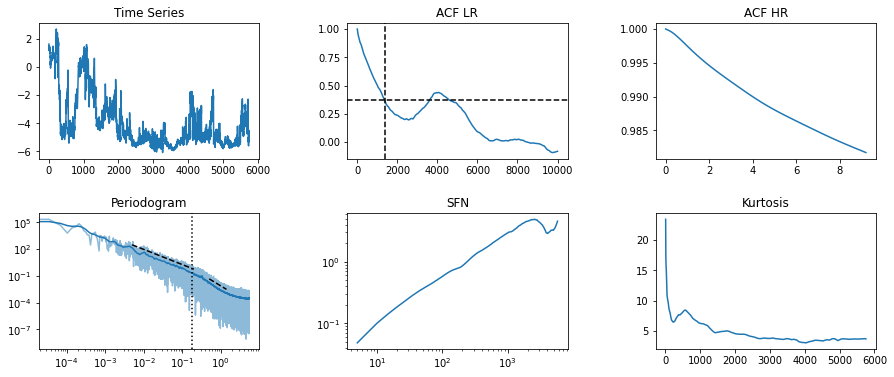

In [60]:
plot_stats(stats_dict)

In [25]:
for key, value in stats_dict.items():
    print(key)
    if type(value) == np.float64:
        print(value)
    elif len(value) > 5:
        print(value[:5])
    else:
        print(value)

time_lags_lr
[ 0.  5. 10. 15. 20.]
time_lags_hr
[0.    0.092 0.184 0.276 0.368]
xi
[0.005      0.0069697  0.00893939 0.01090909 0.01287879]
xk
[0.5        0.50909091 0.51818182 0.52727273 0.53636364]
pi
[100.84153628  57.26421427  37.47290697  26.69167876  20.11677356]
pk
[0.01527062 0.01456398 0.01390169 0.01328026 0.01269654]
acf_lr
[1.         0.99256049 0.98464091 0.97798035 0.97200603]
acf_hr
[1.         0.99986739 0.99972659 0.99954733 0.99933431]
slope_i
-1.7037542744652379
slope_k
-2.629485779350116
break_s
0.17931647345968404
corr_scale_exp_trick
1367.772
corr_scale_exp_fit
1413.7890118520186
corr_scale_int
2282.2665677717396
taylor_scale_u
12.98815218245744
taylor_scale_u_std
0.11192358240395305
taylor_scale_c
9.187955105894927
taylor_scale_c_std
0.07917591632529532
f_periodogram
[0.00000000e+00 3.47222753e-05 6.94445505e-05 1.04166826e-04
 1.38889101e-04]
power_periodogram
[3.0756151e-09 2.2129595e+05 4.5238250e+04 6.2647603e+03 2.5111287e+04]
p_smooth
[3.0756151e-09 1.21957